In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
# import own modules
from src.mnist import Mnist
from src.nntorch import MLP

In [2]:
# Check if MPS is available
#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")

# Set the number of threads to the maximum available
num_cores = torch.get_num_threads()
torch.set_num_threads(num_cores)

# Print the number of threads being used
print(f"Using {torch.get_num_threads()} threads")

Using 10 threads


# MNIST - Modelo ANN

## Introducción
Se propone utilizar una red neuronal artificial como modelo de clasificación multiclase. Las dimensiones de las capas de entrada y salida son: 784 y 10. las mismas se corresponden con el número de píxeles de la imagen y el número de clases (de 0 a 9). Inicialmente se propone utilizar una sola capa oculta. Luego se realizarán pruebas con mayor número de capas ocultas. El conjunto de datos es dividido en tres conjuntos: entrenamiento (*training*), validación (*validation*) y prueba (*test*). El número de imágenes en cada uno resulta: 50.000, 10.000 y 10.000, respectivamente.

Los datos de entrada son normalizados entre 0 y 1, los cuales corresponden a negro y blanco, respectivamente. En la salida se utiliza una función de activación *softmax*, versión extendida de la función *sigmoid* pero a multiclase. Cada neurona de la capa de salida representa la probabilidad de obtener cada clase. Debido a esto, se propone utilizar la función de activación *sigmoide* en las capas ocultas, para preservar los valores de las salidas intermedias entre 0 y 1. De esta manera el dominio queda acotado. Sin embargo, se presenta la principal desventaja potencial de la forma funcional de la función *sigmoide*, donde para valores $|z| >> 1$ la neurona satura, su derivada se hace nula y por lo tanto el modelo no aprende.

Se propone entrenar el modelo con dos algorimtos distintos: SGD y Adam. Para estos entrenamientos y su posterior visualización de performance, se consideran: factor de regularización nulo y una capa oculta con 30 neuronas. La tasa de aprendizaje se ajusta a medida, por prueba, error e intuición, como un primer acercamiento para cada uno de los algoritmos, con el fin de observar su convergencia en el aprendizaje. Los modelos son entrenados durante 400 épocas.

Se propone deterinar algunos hiper-parámetros:
- Tasa de aprendizaje (*learning rate*) $\eta$
- Número de neuronas en la capa oculta (*hidden neurons*) $h_n$
- Factor de regularización (*regularization*) $\lambda$

Por último, se entrena el modelo con los hiper-parámetros óptimos hallados, según 2, 3 y 4 capas ocultas, con el fin de observar el efecto del gradiente desvaneciente (*vanishing gradient*). Se evalúa el rendimiento para cada uno de estos casos.

In [3]:
db = Mnist(fileName='data/mnist.pkl.gz')
batch_size = 100
train_batches = db.getBatches(db.X_train, db.y_train, batch_size, tensor=True)
val_batches = db.getBatches(db.X_val, db.y_val, batch_size, tensor=True)
test_batches = db.getBatches(db.X_test, db.y_test, batch_size, tensor=True)

### Caso 1
- Modelo: MLP con [784, 30, 10]
- Funciones de activación: Leaky ReLU
- Función de pérdida: Cross Entropy
- Epocas = 400
- Sets: Train=50000 | Validation=10.000 | Test=10.000
- Lambda: 0
- Optimizer: SGD or ADAM

In [4]:
layers = [784, 30, 10]
activations = [F.sigmoid]
loss_fn = nn.CrossEntropyLoss
epochs = 400

In [5]:
# Use SGD algorithm with learning rate 0.15
lr = 0.15
model_sgd = MLP(sizes=layers, activations=activations, loss_fn=loss_fn)
model_sgd.to(device)
metrics_sgd = model_sgd.train(train_batches, optimizer=optim.SGD, epochs=epochs, 
                              lr=lr, eval_batches=val_batches, monitor_train=True, verbose=True, epch_print=100)

Epoch 100/400: Loss (1.704, 1.707) 	 Accuracy (76.01%, 75.40%)
Epoch 200/400: Loss (1.692, 1.7) 	 Accuracy (77.04%, 76.13%)
Epoch 300/400: Loss (1.604, 1.614) 	 Accuracy (86.30%, 84.89%)
Epoch 400/400: Loss (1.595, 1.609) 	 Accuracy (87.07%, 85.21%)


In [6]:
# Use Adam algorithm with learning rate 1e-3
lr = 1e-3
model_adam = MLP(sizes=layers, activations=activations, loss_fn=loss_fn)
metrics_adam = model_adam.train(train_batches, optimizer=optim.Adam, epochs=epochs, 
                                lr=lr, eval_batches=val_batches, monitor_train=True, verbose=True, epch_print=100)

Epoch 100/400: Loss (1.481, 1.512) 	 Accuracy (98.22%, 94.95%)
Epoch 200/400: Loss (1.476, 1.511) 	 Accuracy (98.56%, 94.99%)
Epoch 300/400: Loss (1.475, 1.511) 	 Accuracy (98.65%, 95.00%)
Epoch 400/400: Loss (1.474, 1.512) 	 Accuracy (98.71%, 94.95%)


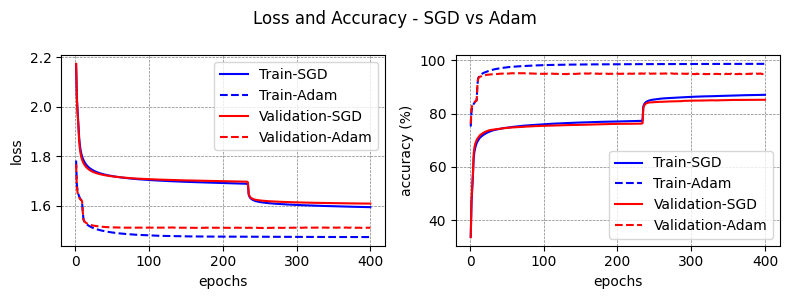

In [7]:
# plot the loss and accuracy togheter in two subplots horizontally
epochs_vec = range(1, epochs+1)
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(epochs_vec, metrics_sgd['loss'][0], c='blue', ls='-', label='Train-SGD')
axs[0].plot(epochs_vec, metrics_adam['loss'][0], c='blue', ls='--', label='Train-Adam')
axs[0].plot(epochs_vec, metrics_sgd['loss'][1], c='red', ls='-', label='Validation-SGD')
axs[0].plot(epochs_vec, metrics_adam['loss'][1], c='red', ls='--', label='Validation-Adam')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[0].legend(loc='upper right')
axs[0].grid(color='gray', linestyle='--', linewidth=0.5)
axs[1].plot(epochs_vec, 100*np.array(metrics_sgd['accuracy'][0]), c='blue', ls='-', label='Train-SGD')
axs[1].plot(epochs_vec, 100*np.array(metrics_adam['accuracy'][0]), c='blue', ls='--', label='Train-Adam')
axs[1].plot(epochs_vec, 100*np.array(metrics_sgd['accuracy'][1]), c='red', ls='-', label='Validation-SGD')
axs[1].plot(epochs_vec, 100*np.array(metrics_adam['accuracy'][1]), c='red', ls='--', label='Validation-Adam')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy (%)')
axs[1].legend(loc='lower right')
axs[1].grid(color='gray', linestyle='--', linewidth=0.5)
plt.suptitle('Loss and Accuracy - SGD vs Adam')
plt.tight_layout()
plt.savefig("figures/model/loss_accuracy_sgd_adam.png")
plt.show()

In [8]:
# print final accuracy results on train, validation and test sets
print('Final accuracy results:')
print("-"*25)
print('Train-SGD: {:.2f}%'.format(100*metrics_sgd['accuracy'][0][-1]))
print('Validation-SGD: {:.2f}%'.format(100*metrics_sgd['accuracy'][1][-1]))
print('Test-SGD: {:.2f}%'.format(100*model_sgd.accuracy(test_batches)))
print("-"*25)
print('Train-Adam: {:.2f}%'.format(100*metrics_adam['accuracy'][0][-1]))
print('Validation-Adam: {:.2f}%'.format(100*metrics_adam['accuracy'][1][-1]))
print('Test-Adam: {:.2f}%'.format(100*model_adam.accuracy(test_batches)))

Final accuracy results:
-------------------------
Train-SGD: 87.07%
Validation-SGD: 85.21%
Test-SGD: 85.09%
-------------------------
Train-Adam: 98.71%
Validation-Adam: 94.95%
Test-Adam: 94.53%


### Caso 2
- Reduce epochs to 200
- Hyperparameter: learning rate. $\eta \in [1\times 10^{-5}, 1\times 10^{-1}]$
- Adam optimizer

In [9]:
# Use Adam algorithm with learning rate in [10e-5, 10e-1]
epochs = 200
lr = np.logspace(-5, -1, 20)
metrics_lr_adam = []
for value in lr:
    model_lr_adam = MLP(sizes=layers, activations=activations, loss_fn=loss_fn)
    metrics_lr_adam.append(model_lr_adam.train(train_batches, optimizer=optim.Adam, epochs=epochs, lr=value, 
                                               eval_batches=val_batches, monitor_train=True, only_last=True))

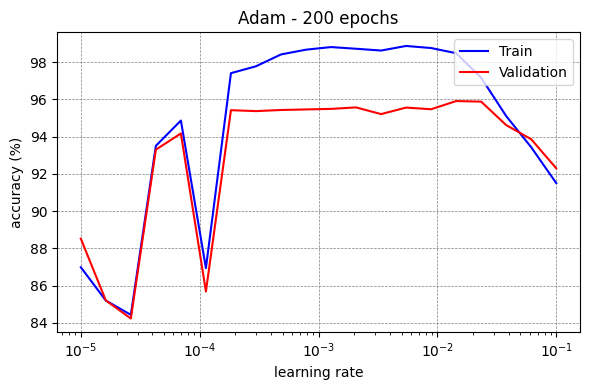

In [10]:
# plot accuracy against the learning rate
acc_train_lr_adam = [100*metric['accuracy'][0][-1] for metric in metrics_lr_adam]
acc_val_lr_adam = [100*metric['accuracy'][1][-1] for metric in metrics_lr_adam]
fig = plt.figure(figsize=(6, 4))
plt.plot(lr, acc_train_lr_adam, c='blue', ls='-', label='Train')
plt.plot(lr, acc_val_lr_adam, c='red', ls='-', label='Validation')
plt.xscale('log')
plt.xlabel('learning rate')
plt.ylabel('accuracy (%)')
plt.legend(loc='upper right')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title('Adam - 200 epochs')
plt.tight_layout()
plt.savefig("figures/model/accuracy_lr_adam.png")
plt.show()

In [11]:
# get the optimal learning rate for Adam algorithm
idx = np.argmax(acc_val_lr_adam)
lr_opt = lr[idx]
model_lr_adam.initializeParameters()
_ = model_lr_adam.train(train_batches, optimizer=optim.Adam, epochs=epochs, lr=lr_opt, only_last=True)

In [12]:
print('Optimal learning rate for Adam: {:.2e}.'.format(lr_opt))
print("Accuracy obtained on train set: {:.2f}%".format(100*model_lr_adam.accuracy(train_batches)))
print('Accuracy obtained on validation set: {:.2f}%'.format(100*model_lr_adam.accuracy(val_batches)))
print("Accuracy obtained on test set: {:.2f}%".format(100*model_lr_adam.accuracy(test_batches)))

Optimal learning rate for Adam: 1.44e-02.
Accuracy obtained on train set: 98.32%
Accuracy obtained on validation set: 95.28%
Accuracy obtained on test set: 95.30%


### Caso 3
- Epochs: 200
- Algorithm: Adam optimizer
- Learning rate: optim
- Hyperparameter $h_n$ (number of hidden neurons)
- $h_n \in [30, 300]$

In [13]:
activations = [F.sigmoid]
loss_fn = nn.CrossEntropyLoss
epochs = 200

metrics_hn = []
hidden_neurons = np.linspace(30, 300, 10).astype(int)
for hn in hidden_neurons:
    layers = [784, hn, 10]
    model_hn = MLP(sizes=layers, activations=activations, loss_fn=loss_fn, params="normal")
    metrics_hn.append(model_hn.train(train_batches, optimizer=optim.Adam, epochs=epochs, lr=lr_opt, 
                                  eval_batches=val_batches, monitor_train=True, only_last=True))
    print(f"Training with {hn} hidden neurons completed.")
acc_train_hn = [100*m['accuracy'][0][-1] for m in metrics_hn]
acc_val_hn = [100*m['accuracy'][1][-1] for m in metrics_hn]

Training with 30 hidden neurons completed.
Training with 60 hidden neurons completed.
Training with 90 hidden neurons completed.
Training with 120 hidden neurons completed.
Training with 150 hidden neurons completed.
Training with 180 hidden neurons completed.
Training with 210 hidden neurons completed.
Training with 240 hidden neurons completed.
Training with 270 hidden neurons completed.
Training with 300 hidden neurons completed.


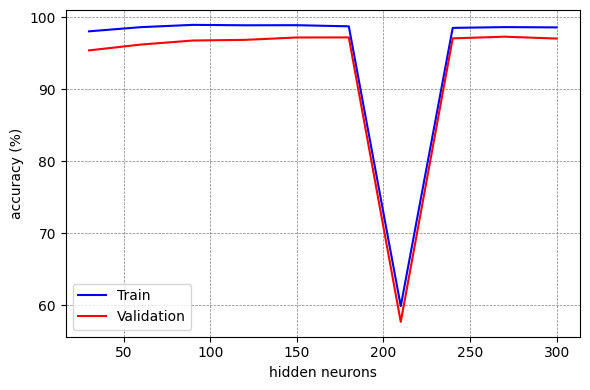

In [14]:
# plot accuracy against the learning rate
fig = plt.figure(figsize=(6, 4))
plt.plot(hidden_neurons, acc_train_hn, c='blue', ls='-', label='Train')
plt.plot(hidden_neurons, acc_val_hn, c='red', ls='-', label='Validation')
plt.xlabel('hidden neurons')
plt.ylabel('accuracy (%)')
plt.legend(loc='best')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
#plt.title('Adam - 200 epochs')
plt.tight_layout()
plt.savefig("figures/model/accuracy_hidden_neurons.png")
plt.show()

In [15]:
# get the optimal learning rate for Adam algorithm
idx = np.argmax(acc_val_hn)
hn_opt = hidden_neurons[idx]
layers = [784, hn_opt, 10]
model_hn = MLP(sizes=layers, activations=activations, loss_fn=loss_fn, params="normal")
_ = model_hn.train(train_batches, optimizer=optim.Adam, epochs=epochs, lr=lr_opt, only_last=True)

In [16]:
print('Optimal hidden neurons: {}.'.format(hn_opt))
print("Accuracy obtained on train set: {:.2f}%".format(100*model_hn.accuracy(train_batches)))
print('Accuracy obtained on validation set: {:.2f}%'.format(100*model_hn.accuracy(val_batches)))
print("Accuracy obtained on test set: {:.2f}%".format(100*model_hn.accuracy(test_batches)))

Optimal hidden neurons: 270.
Accuracy obtained on train set: 97.73%
Accuracy obtained on validation set: 96.22%
Accuracy obtained on test set: 96.19%


### Caso 4
- Epochs: 200
- Algorithm: Adam optimizer
- Learning rate: optim
- Hidden neurons: 50 (without lose of accuracy)
- Hyperparameter $\lambda$ (regularization factor)
- $\lambda \in [10^{-7}, 10^{-2}]$

In [17]:
layers = [784, 50, 10]
activations = [F.sigmoid]
loss_fn = nn.CrossEntropyLoss
epochs = 200
model_lmbda = MLP(sizes=layers, activations=activations, loss_fn=loss_fn)

metrics_lmbda = []
lmbda = np.logspace(-7, -2, 10)
for lda in lmbda:
    model_lmbda.initializeParameters(params="normal")
    metrics_lmbda.append(model_lmbda.train(train_batches, optimizer=optim.Adam, epochs=epochs, lr=lr_opt, 
                                           regularization=lda, eval_batches=val_batches, monitor_train=True, only_last=True))
    print(f"Training with lambda={lda:.2e} completed.")
acc_train_lmbda = [100*m['accuracy'][0][-1] for m in metrics_lmbda]
acc_val_lmbda = [100*m['accuracy'][1][-1] for m in metrics_lmbda]

Training with lambda=1.00e-07 completed.
Training with lambda=3.59e-07 completed.
Training with lambda=1.29e-06 completed.
Training with lambda=4.64e-06 completed.
Training with lambda=1.67e-05 completed.
Training with lambda=5.99e-05 completed.
Training with lambda=2.15e-04 completed.
Training with lambda=7.74e-04 completed.
Training with lambda=2.78e-03 completed.
Training with lambda=1.00e-02 completed.


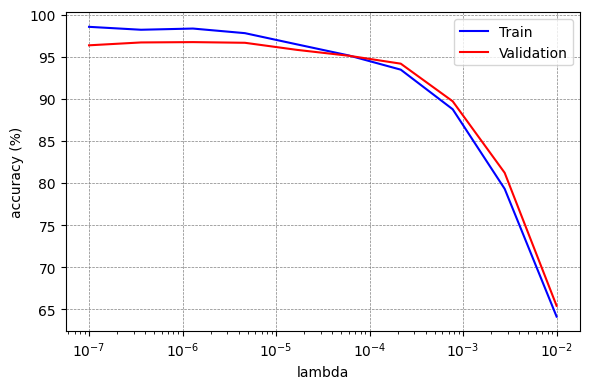

In [18]:
# plot accuracy against the learning rate
fig = plt.figure(figsize=(6, 4))
plt.plot(lmbda, acc_train_lmbda, c='blue', ls='-', label='Train')
plt.plot(lmbda, acc_val_lmbda, c='red', ls='-', label='Validation')
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('accuracy (%)')
plt.legend(loc='upper right')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
#plt.title('Adam - 200 epochs')
plt.tight_layout()
plt.savefig("figures/model/accuracy_lambda.png")
plt.show()

In [19]:
# get the optimal regularization parameter for Adam algorithm
idx = np.argmax(acc_val_lmbda)
lmbda_opt = lmbda[idx]
model_lmbda = MLP(sizes=layers, activations=activations, loss_fn=loss_fn, params="normal")
_ = model_lmbda.train(train_batches, optimizer=optim.Adam, epochs=epochs, lr=lr_opt, regularization=lmbda_opt, only_last=True)

In [20]:
print('Optimal regularization factor: {:.2g}.'.format(lmbda_opt))
print("Accuracy obtained on train set: {:.2f}%".format(100*model_lmbda.accuracy(train_batches)))
print('Accuracy obtained on validation set: {:.2f}%'.format(100*model_lmbda.accuracy(val_batches)))
print("Accuracy obtained on test set: {:.2f}%".format(100*model_lmbda.accuracy(test_batches)))

Optimal regularization factor: 1.3e-06.
Accuracy obtained on train set: 98.40%
Accuracy obtained on validation set: 96.69%
Accuracy obtained on test set: 96.83%


### Caso 5
Vanishing gradient
- Use all optimized variables: $\eta, \lambda$
- 30 hidden neurons
- Use Adam algorithm
- Run over 400 epochs
- Use different number of hidden layers: 2, 3 and 4

In [23]:
# model with 2 hidden layers (same number of neurons)
layers = [784, 50, 50, 10]
activations = [F.sigmoid, F.sigmoid]
loss_fn = nn.CrossEntropyLoss
epochs = 400

model_2hl = MLP(sizes=layers, activations=activations, loss_fn=loss_fn, params="normal")
metrics_2hl = model_2hl.train(train_batches, optimizer=optim.Adam, epochs=epochs, lr=lr_opt, 
                              regularization=lmbda_opt, eval_batches=val_batches, monitor_train=True, 
                              monitor_params=True, monitor_params_layer=True, verbose=True, epch_print=50)

Epoch 50/400: Loss (1.497, 1.505) 	 Accuracy (96.40%, 95.62%)
Epoch 100/400: Loss (1.488, 1.497) 	 Accuracy (97.30%, 96.46%)
Epoch 150/400: Loss (1.495, 1.5) 	 Accuracy (96.68%, 96.07%)
Epoch 200/400: Loss (1.493, 1.502) 	 Accuracy (96.84%, 95.88%)
Epoch 250/400: Loss (1.487, 1.495) 	 Accuracy (97.46%, 96.67%)
Epoch 300/400: Loss (1.487, 1.5) 	 Accuracy (97.45%, 96.15%)
Epoch 350/400: Loss (1.488, 1.496) 	 Accuracy (97.40%, 96.57%)
Epoch 400/400: Loss (1.49, 1.499) 	 Accuracy (97.13%, 96.17%)


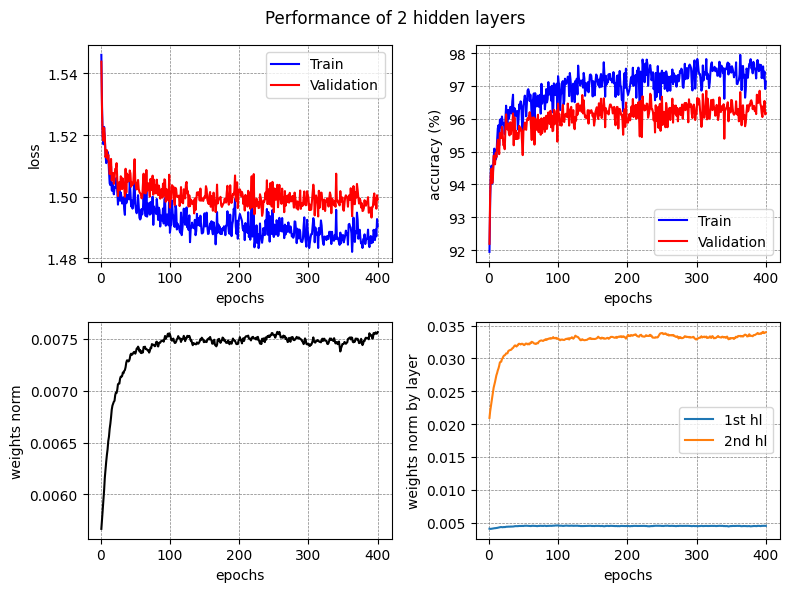

In [25]:
# reshape weight norms by layer
norms_first_hl = [norm_epoch[0] for norm_epoch in metrics_2hl['norm'][1]]
norms_second_hl = [norm_epoch[1] for norm_epoch in metrics_2hl['norm'][1]]

# plot: loss, accuracy and weights
epochs_vec = range(1, epochs+1)
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0,0].plot(epochs_vec, metrics_2hl['loss'][0], c='blue', ls='-', label='Train')
axs[0,0].plot(epochs_vec, metrics_2hl['loss'][1], c='red', ls='-', label='Validation')
axs[0,0].set_xlabel('epochs')
axs[0,0].set_ylabel('loss')
axs[0,0].legend(loc='best')
axs[0,0].grid(color='gray', linestyle='--', linewidth=0.5)
axs[0,1].plot(epochs_vec, 100*np.array(metrics_2hl['accuracy'][0]), c='blue', ls='-', label='Train')
axs[0,1].plot(epochs_vec, 100*np.array(metrics_2hl['accuracy'][1]), c='red', ls='-', label='Validation')
axs[0,1].set_xlabel('epochs')
axs[0,1].set_ylabel('accuracy (%)')
axs[0,1].legend(loc='best')
axs[0,1].grid(color='gray', linestyle='--', linewidth=0.5)
axs[1,0].plot(epochs_vec, metrics_2hl['norm'][0], c='black', ls='-')
axs[1,0].set_xlabel('epochs')
axs[1,0].set_ylabel('weights norm')
axs[1,0].grid(color='gray', linestyle='--', linewidth=0.5)
axs[1,1].plot(epochs_vec, norms_first_hl, ls='-', label='1st hl')
axs[1,1].plot(epochs_vec, norms_second_hl, ls='-', label='2nd hl')
axs[1,1].set_xlabel('epochs')
axs[1,1].set_ylabel('weights norm by layer')
axs[1,1].legend(loc='best')
axs[1,1].grid(color='gray', linestyle='--', linewidth=0.5)

plt.suptitle('Performance of 2 hidden layers')
plt.tight_layout()
plt.savefig("figures/model/performance_2hl.png")
plt.show()

In [26]:
print("2 hidden layers model:")
print("Accuracy obtained on train set: {:.2f}%".format(100*model_2hl.accuracy(train_batches)))
print('Accuracy obtained on validation set: {:.2f}%'.format(100*model_2hl.accuracy(val_batches)))
print("Accuracy obtained on test set: {:.2f}%".format(100*model_2hl.accuracy(test_batches)))

2 hidden layers model:
Accuracy obtained on train set: 97.13%
Accuracy obtained on validation set: 96.17%
Accuracy obtained on test set: 96.05%


In [27]:
# model with 3 hidden layers (same number of neurons)
layers = [784, 50, 50, 50, 10]
activations = [F.sigmoid, F.sigmoid, F.sigmoid]
loss_fn = nn.CrossEntropyLoss
epochs = 400

model_3hl = MLP(sizes=layers, activations=activations, loss_fn=loss_fn, params="uniform")
metrics_3hl = model_3hl.train(train_batches, optimizer=optim.Adam, epochs=epochs, lr=lr_opt, 
                              regularization=lmbda_opt, eval_batches=val_batches, monitor_train=True, 
                              monitor_params=True, monitor_params_layer=True, verbose=True, epch_print=50)

Epoch 50/400: Loss (1.507, 1.508) 	 Accuracy (95.40%, 95.31%)
Epoch 100/400: Loss (1.502, 1.509) 	 Accuracy (95.95%, 95.21%)
Epoch 150/400: Loss (1.499, 1.505) 	 Accuracy (96.24%, 95.58%)
Epoch 200/400: Loss (1.5, 1.506) 	 Accuracy (96.10%, 95.57%)
Epoch 250/400: Loss (1.504, 1.509) 	 Accuracy (95.72%, 95.28%)
Epoch 300/400: Loss (1.502, 1.508) 	 Accuracy (95.92%, 95.28%)
Epoch 350/400: Loss (1.493, 1.503) 	 Accuracy (96.81%, 95.89%)
Epoch 400/400: Loss (1.498, 1.507) 	 Accuracy (96.40%, 95.44%)


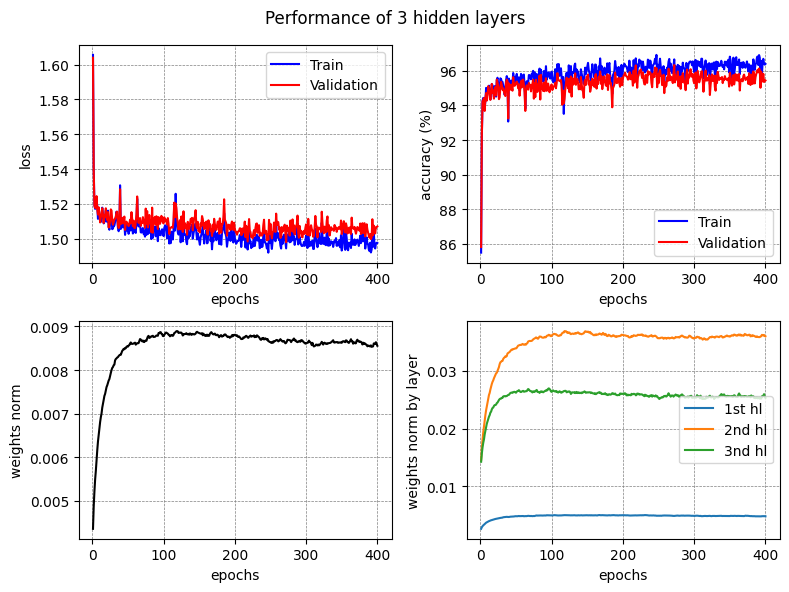

In [30]:
# reshape weight norms by layer
norms_first_hl = [norm_epoch[0] for norm_epoch in metrics_3hl['norm'][1]]
norms_second_hl = [norm_epoch[1] for norm_epoch in metrics_3hl['norm'][1]]
norms_third_hl = [norm_epoch[2] for norm_epoch in metrics_3hl['norm'][1]]

# plot: loss, accuracy and weights
epochs = 400
epochs_vec = range(1, epochs+1)
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0,0].plot(epochs_vec, metrics_3hl['loss'][0], c='blue', ls='-', label='Train')
axs[0,0].plot(epochs_vec, metrics_3hl['loss'][1], c='red', ls='-', label='Validation')
axs[0,0].set_xlabel('epochs')
axs[0,0].set_ylabel('loss')
axs[0,0].legend(loc='best')
axs[0,0].grid(color='gray', linestyle='--', linewidth=0.5)
axs[0,1].plot(epochs_vec, 100*np.array(metrics_3hl['accuracy'][0]), c='blue', ls='-', label='Train')
axs[0,1].plot(epochs_vec, 100*np.array(metrics_3hl['accuracy'][1]), c='red', ls='-', label='Validation')
axs[0,1].set_xlabel('epochs')
axs[0,1].set_ylabel('accuracy (%)')
axs[0,1].legend(loc='best')
axs[0,1].grid(color='gray', linestyle='--', linewidth=0.5)
axs[1,0].plot(epochs_vec, metrics_3hl['norm'][0], c='black', ls='-')
axs[1,0].set_xlabel('epochs')
axs[1,0].set_ylabel('weights norm')
axs[1,0].grid(color='gray', linestyle='--', linewidth=0.5)
axs[1,1].plot(epochs_vec, norms_first_hl, ls='-', label='1st hl')
axs[1,1].plot(epochs_vec, norms_second_hl, ls='-', label='2nd hl')
axs[1,1].plot(epochs_vec, norms_third_hl, ls='-', label='3nd hl')
axs[1,1].set_xlabel('epochs')
axs[1,1].set_ylabel('weights norm by layer')
axs[1,1].legend(loc='center right')
axs[1,1].grid(color='gray', linestyle='--', linewidth=0.5)

plt.suptitle('Performance of 3 hidden layers')
plt.tight_layout()
plt.savefig("figures/model/performance_3hl.png")
plt.show()

In [31]:
print("3 hidden layers model:")
print("Accuracy obtained on train set: {:.2f}%".format(100*model_3hl.accuracy(train_batches)))
print('Accuracy obtained on validation set: {:.2f}%'.format(100*model_3hl.accuracy(val_batches)))
print("Accuracy obtained on test set: {:.2f}%".format(100*model_3hl.accuracy(test_batches)))

3 hidden layers model:
Accuracy obtained on train set: 96.40%
Accuracy obtained on validation set: 95.44%
Accuracy obtained on test set: 95.67%


In [32]:
# model with 4 hidden layers (same number of neurons)
layers = [784, 50, 50, 50, 50, 10]
activations = [F.sigmoid, F.sigmoid, F.sigmoid, F.sigmoid]
loss_fn = nn.CrossEntropyLoss
epochs = 400

model_4hl = MLP(sizes=layers, activations=activations, loss_fn=loss_fn, params="uniform")
metrics_4hl = model_4hl.train(train_batches, optimizer=optim.Adam, epochs=epochs, lr=lr_opt, 
                              regularization=lmbda_opt, eval_batches=val_batches, monitor_train=True, 
                              monitor_params=True, monitor_params_layer=True, verbose=True, epch_print=50)

Epoch 50/400: Loss (1.519, 1.518) 	 Accuracy (94.24%, 94.26%)
Epoch 100/400: Loss (1.522, 1.521) 	 Accuracy (93.94%, 93.91%)
Epoch 150/400: Loss (1.515, 1.515) 	 Accuracy (94.58%, 94.65%)
Epoch 200/400: Loss (1.508, 1.511) 	 Accuracy (95.33%, 94.96%)
Epoch 250/400: Loss (1.513, 1.516) 	 Accuracy (94.86%, 94.52%)
Epoch 300/400: Loss (1.51, 1.513) 	 Accuracy (95.07%, 94.76%)
Epoch 350/400: Loss (1.513, 1.517) 	 Accuracy (94.79%, 94.48%)
Epoch 400/400: Loss (1.509, 1.513) 	 Accuracy (95.13%, 94.81%)


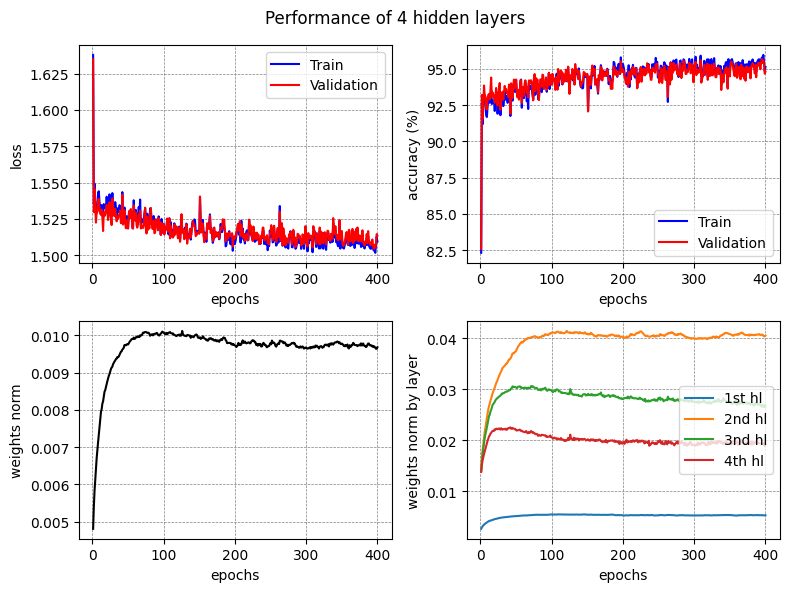

In [33]:
# reshape weight norms by layer
norms_first_hl = [norm_epoch[0] for norm_epoch in metrics_4hl['norm'][1]]
norms_second_hl = [norm_epoch[1] for norm_epoch in metrics_4hl['norm'][1]]
norms_third_hl = [norm_epoch[2] for norm_epoch in metrics_4hl['norm'][1]]
norms_fourth_hl = [norm_epoch[3] for norm_epoch in metrics_4hl['norm'][1]]

# plot: loss, accuracy and weights
epochs = 400
epochs_vec = range(1, epochs+1)
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0,0].plot(epochs_vec, metrics_4hl['loss'][0], c='blue', ls='-', label='Train')
axs[0,0].plot(epochs_vec, metrics_4hl['loss'][1], c='red', ls='-', label='Validation')
axs[0,0].set_xlabel('epochs')
axs[0,0].set_ylabel('loss')
axs[0,0].legend(loc='best')
axs[0,0].grid(color='gray', linestyle='--', linewidth=0.5)
axs[0,1].plot(epochs_vec, 100*np.array(metrics_4hl['accuracy'][0]), c='blue', ls='-', label='Train')
axs[0,1].plot(epochs_vec, 100*np.array(metrics_4hl['accuracy'][1]), c='red', ls='-', label='Validation')
axs[0,1].set_xlabel('epochs')
axs[0,1].set_ylabel('accuracy (%)')
axs[0,1].legend(loc='best')
axs[0,1].grid(color='gray', linestyle='--', linewidth=0.5)
axs[1,0].plot(epochs_vec, metrics_4hl['norm'][0], c='black', ls='-')
axs[1,0].set_xlabel('epochs')
axs[1,0].set_ylabel('weights norm')
axs[1,0].grid(color='gray', linestyle='--', linewidth=0.5)
axs[1,1].plot(epochs_vec, norms_first_hl, ls='-', label='1st hl')
axs[1,1].plot(epochs_vec, norms_second_hl, ls='-', label='2nd hl')
axs[1,1].plot(epochs_vec, norms_third_hl, ls='-', label='3nd hl')
axs[1,1].plot(epochs_vec, norms_fourth_hl, ls='-', label='4th hl')
axs[1,1].set_xlabel('epochs')
axs[1,1].set_ylabel('weights norm by layer')
axs[1,1].legend(loc='center right')
axs[1,1].grid(color='gray', linestyle='--', linewidth=0.5)

plt.suptitle('Performance of 4 hidden layers')
plt.tight_layout()
plt.savefig("figures/model/performance_4hl.png")
plt.show()

In [34]:
print("4 hidden layers model:")
print("Accuracy obtained on train set: {:.2f}%".format(100*model_4hl.accuracy(train_batches)))
print('Accuracy obtained on validation set: {:.2f}%'.format(100*model_4hl.accuracy(val_batches)))
print("Accuracy obtained on test set: {:.2f}%".format(100*model_4hl.accuracy(test_batches)))

4 hidden layers model:
Accuracy obtained on train set: 95.13%
Accuracy obtained on validation set: 94.81%
Accuracy obtained on test set: 94.54%
